Application path not initialized


['PC_OUT', 'Colorised Point Cloud', None, 'False']
['PC', 'Point Cloud', None, 'True']
['POINTS', 'Points', None, 'False']
['PC_OUT', 'Result', None, 'True']
['PC_OUT', 'Result', None, 'True']
['OUTPUT', 'Output', None, 'True']
['OUT', 'Output', None, 'False']
['PC_OUT', 'Point Cloud', None, 'True']
['PC_OUT', 'Point Cloud', None, 'False']
['PC_OUT', 'Point Cloud Classified', None, 'True']
['POINTS', 'Points', None, 'True']
['THINNED_PC', 'Thinned Points', None, 'False']
['PC_OUT', 'Merged Point Cloud', None, 'False']
['RESULT', 'Thinned Points', None, 'True']
['POINTS', 'Points', None, 'False']
['PC_OUT', 'Filtered Points', None, 'True']
['POINTS', 'Points', None, 'False']
['TARGET_PC', 'Target', None, 'False']
['POINTS', 'Points', None, 'False']
['TARGET_PC', 'Target', None, 'False']
['PC_OUT', 'Colorised Point Cloud', None, 'False']
['PC', 'Point Cloud', None, 'True']
['POINTS', 'Points', None, 'False']
['PC_OUT', 'Result', None, 'True']
['PC_OUT', 'Result', None, 'True']
['OUTPUT',

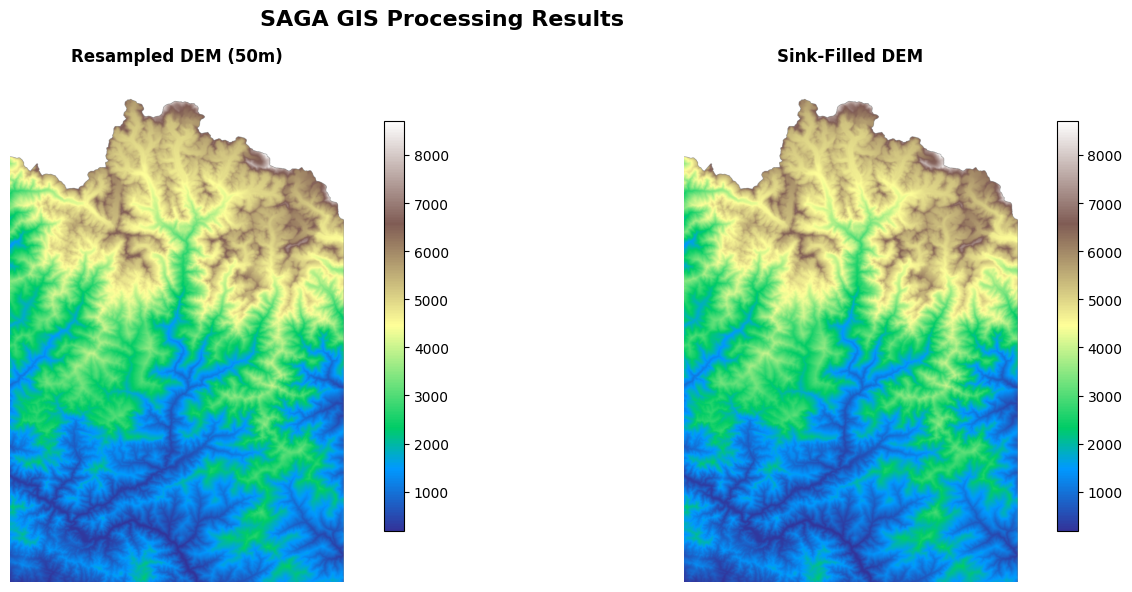

Saved plot as processing_results.png


In [ ]:
!pip install rasterio matplotlib
# QGIS SAGA NextGen Processing - Production Ready
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import numpy as np

def initialize_qgis_saga():
    """Initialize QGIS with SAGA NextGen provider"""
    # Environment setup
    os.environ['QT_QPA_PLATFORM'] = 'offscreen'
    
    # Suppress verbose output
    import logging
    logging.getLogger().setLevel(logging.ERROR)
    
    # QGIS initialization
    from qgis.core import QgsApplication, QgsSettings
    from qgis import processing
    
    QgsApplication.setPrefixPath('/opt/conda/envs/pygile', True)
    qgs = QgsApplication([], False)
    qgs.initQgis()
    
    # Initialize processing
    from processing.core.Processing import Processing
    Processing.initialize()
    
    # Configure SAGA settings
    settings = QgsSettings()
    settings.setValue("Processing/configuration/SAGANG_FOLDER", "/opt/saga")
    settings.setValue("Processing/configuration/SAGANG_ACTIVATE", True)
    
    # Load SAGA provider
    plugin_path = Path('/root/.local/share/QGIS/QGIS3/profiles/default/python/plugins/processing_saga_nextgen')
    
    if plugin_path.exists():
        sys.path.insert(0, str(plugin_path))
        from processing_saga_nextgen.processing.provider import SagaNextGenAlgorithmProvider
        
        provider = SagaNextGenAlgorithmProvider()
        provider.load()
        
        registry = QgsApplication.processingRegistry()
        registry.addProvider(provider)
        
        return qgs, processing, registry
    
    return None, None, None

def get_saga_algorithms(registry):
    """Get available SAGA algorithms"""
    saga_algs = [alg.id() for alg in registry.algorithms() if alg.provider().id() == 'sagang']
    
    algorithms = {
        'resample': next((alg for alg in saga_algs if 'resamp' in alg.lower()), None),
        'fill_sinks': next((alg for alg in saga_algs if 'sink' in alg.lower()), None)
    }
    
    return algorithms

def process_dem(processing, algorithms, input_dem, output_dir, cell_size=50):
    """Process DEM through SAGA pipeline"""
    results = {}
    
    if not Path(input_dem).exists():
        return results
    
    # Create output directory
    Path(output_dir).mkdir(exist_ok=True)
    
    # 1. Resample DEM
    if algorithms['resample']:
        dem_50m = f"{output_dir}/dem_50m.tif"
        processing.run(algorithms['resample'], {
            'INPUT': input_dem,
            'OUTPUT': dem_50m,
            'TARGET_USER_SIZE': cell_size
        })
        results['resampled'] = dem_50m
    
    # 2. Fill sinks
    if algorithms['fill_sinks'] and 'resampled' in results:
        filled_dem = f"{output_dir}/filled_dem.tif"
        processing.run(algorithms['fill_sinks'], {
            'DEM': results['resampled'],
            'RESULT': filled_dem
        })
        results['filled'] = filled_dem
    
    return results

def visualize_results(results):
    """Create visualization of processed results"""
    available_results = [k for k in ['resampled', 'filled'] if k in results]
    n_plots = len(available_results)
    
    if n_plots == 0:
        return None
    
    # Create subplot layout
    if n_plots == 1:
        fig, axes = plt.subplots(1, 1, figsize=(8, 6))
        axes = [axes]
    else:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    fig.suptitle('SAGA GIS Processing Results', fontsize=16, fontweight='bold')
    
    dataset_info = {
        'resampled': ('Resampled DEM (50m)', 'terrain'),
        'filled': ('Sink-Filled DEM', 'terrain')
    }
    
    for i, key in enumerate(available_results):
        title, cmap = dataset_info[key]
        ax = axes[i]
        
        try:
            with rasterio.open(results[key]) as src:
                data = src.read(1)
                data = np.ma.masked_where(data == src.nodata, data)
                
                im = ax.imshow(data, cmap=cmap, interpolation='bilinear')
                ax.set_title(title, fontweight='bold')
                ax.axis('off')
                
                # Add colorbar
                plt.colorbar(im, ax=ax, shrink=0.8)
                
        except Exception as e:
            ax.text(0.5, 0.5, f'Error loading\n{key}', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(title, fontweight='bold')
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return fig

def main():
    """Main processing pipeline"""
    # Initialize QGIS and SAGA
    qgs, processing, registry = initialize_qgis_saga()
    
    if not processing:
        print("Could not initialize QGIS and SAGA")
        return
    
    # Get algorithms
    algorithms = get_saga_algorithms(registry)
    available_algs = [k for k, v in algorithms.items() if v]
    
    print(f"Found {len(available_algs)} SAGA algorithms")
    
    # Process DEM
    input_dem = '/workspace/Orig_DEM/Orig_Dem.tif'
    output_dir = '/workspace/output'
    
    print(f"Starting to process {Path(input_dem).name}")
    results = process_dem(processing, algorithms, input_dem, output_dir)
    
    if results:
        print(f"Done. Created {len(results)} files:")
        for key, path in results.items():
            print(f"  {key}: {Path(path).name}")
        
        # Visualize results
        print("Making plots...")
        fig = visualize_results(results)
        
        # Save visualization
        viz_path = f"{output_dir}/processing_results.png"
        fig.savefig(viz_path, dpi=300, bbox_inches='tight')
        print(f"Saved plot as {Path(viz_path).name}")
        
    else:
        print("Nothing was created")
    
    # Cleanup
    qgs.exitQgis()
    
    return results

# Execute main pipeline
if __name__ == "__main__":
    results = main()